# Data Exploration DW

The objective here is exploring the data after the pipelines, to check if it make any sense and propose some interesting information this dataset can provide.

The resulting dataset is a combination of the two most know ways brazilian consumers have to solve their problems. 

The first one, Procon, is a government consumer defence organism available country wide, where you have to fisically or by telephone open a complaint against a company (we are going to call offline).

The second one, consumidor.gov.br, is a site where consumers can make complaints against company, also made available by the Brazilian government.

## Imports  & Config

Imports

In [3]:
import psycopg2
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

Matplotlib custom params

In [4]:
rcParams['axes.titlepad'] = 20
rcParams['axes.titlesize'] = 14
rcParams['axes.labelpad'] = 15
rcParams['axes.xmargin'] = .01

Redshift connection

In [5]:
sql_host = 'udacity-dend.cigt4shvjcj5.us-east-1.redshift.amazonaws.com'
sql_port = 5439
sql_db = 'consumer'
sql_user = 'renato'
sql_password = 'Dxsnah01'
conn = \
    psycopg2.connect(f"host='{sql_host}' port={sql_port} dbname='{sql_db}' user={sql_user} password={sql_password}")

## Checking Data Quality & Analyzing Data

### How many records do we have on the DW?

In [35]:
stmt = """
    select count(*) from ft_complaints;
"""
total_complaints = pandas.read_sql(stmt, conn)
total_complaints.head()

,count
0,9993007


### How does complaints are distributed over time

At first, let's look if there is a change over the years:

[Text(0, 0.5, 'Total of complaints'), Text(0.5, 0, 'Year')]

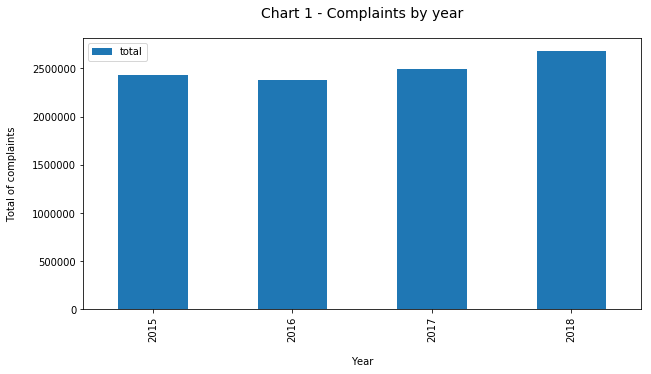

In [23]:
stmt = """
    select 
        dat.year, count(*) as total
    from ft_complaints as c
        left join dm_date as dat on (c.ts = dat.ts)
    group by dat.year    
    ;
"""
complaints_by_year = pandas.read_sql(stmt, conn)
complaints_by_year.set_index('year', inplace=True)

ax = complaints_by_year.sort_values(by='year').plot(kind='bar', title='Chart 1 - Complaints by year', figsize=(10,5))
ax.set(ylabel='Total of complaints', xlabel='Year')

There is a small but not very significant increase over the years, let see if there is a seasonality by month:

[Text(0, 0.5, 'Total of complaints'), Text(0.5, 0, 'Year')]

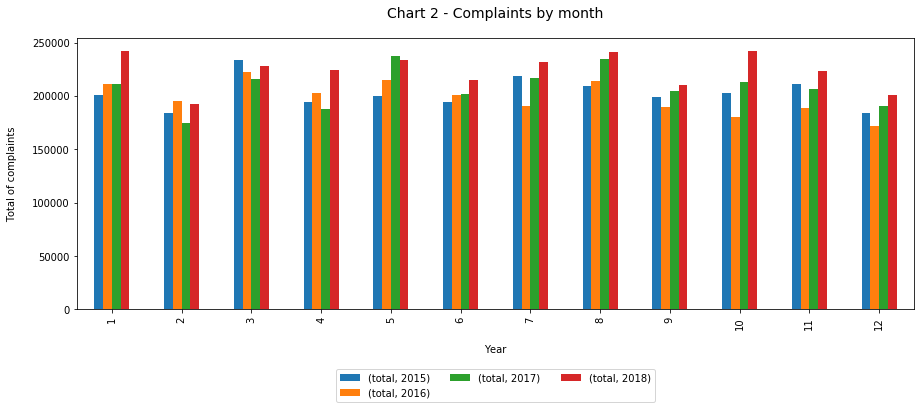

In [34]:
stmt = """
    select 
        dat.year, dat.month, count(*) as total
    from ft_complaints as c
        left join dm_date as dat on (c.ts = dat.ts)
    group by dat.year, dat.month
    ;
"""
complaints_by_month = pandas.read_sql(stmt, conn)
complaints_by_month.set_index(['year','month'], inplace=True)
complaints_by_month = complaints_by_month.unstack(level=0)

ax = complaints_by_month.plot(kind='bar', title='Chart 2 - Complaints by month', figsize=(15,5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)
ax.set(ylabel='Total of complaints', xlabel='Year')

### How many complaints exists by each channel

In [15]:
stmt = """
    select channel, count(*) from ft_complaints group by channel;
"""
complaints_by_channel = pandas.read_sql(stmt, conn)
complaints_by_channel.sort_values(by='count', ascending=False).head()

,channel,count
2,procon,8260975
0,Plataforma Web,1644697
1,Plataforma Android,69360
3,Plataforma IOS,17975


Here we can check the total of rows make sense, everything that came from procon has a procon channel (offline), the others channels are from consumidor.gov.br.

Let's see if there is some difference over the year for each channel:

[Text(0, 0.5, 'Total of complaints'), Text(0.5, 0, 'Year')]

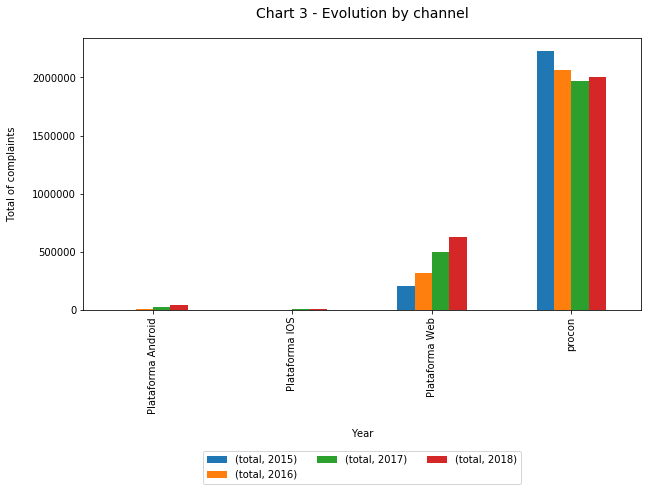

In [40]:
stmt = """
    select 
        dat.year, c.channel, count(*) as total
    from ft_complaints as c
        left join dm_date as dat on (c.ts = dat.ts)
    group by dat.year, c.channel
    ;
"""
complaints_by_channel_year = pandas.read_sql(stmt, conn)
complaints_by_channel_year.set_index(['year','channel'], inplace=True)
complaints_by_channel_year = complaints_by_channel_year.unstack(level=0)
complaints_by_channel_year.head()

ax = complaints_by_channel_year.plot(kind='bar', title='Chart 3 - Evolution by channel', figsize=(10,5))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.50), ncol=3)
ax.set(ylabel='Total of complaints', xlabel='Year')

When checking the evolution by each platform by year, we understand that the offline complaints (procon) are going down while the online methods are increasing, so complaints are keeping the same level, with a small increase over years, but the "traditional" methods are losing space to online ones.

### Complaints by consumer profile

Do we have a pattern by gender?

In [7]:
stmt = """
    select 
        p.gender, count(*)
    from ft_complaints as c
        left join dm_consumer_profile as p on c.consumer_id = p.consumer_id
    group by p.gender 
    ;
"""
complaints_by_gender = pandas.read_sql(stmt, conn)
complaints_by_gender.set_index('gender', inplace=True)
complaints_by_gender.head()

,count
gender,
F,4572941
M,4416705
NaN,1003361


We have a lot of null values on the dataset but it is not very representative. The male and female public represent almost the same for complaints.

Do we have a pattern by age?

In [12]:
stmt = """
    select 
        p.age, count(*)
    from ft_complaints as c
        left join dm_consumer_profile as p on c.consumer_id = p.consumer_id
    group by p.age 
    ;
"""
complaints_by_gender = pandas.read_sql(stmt, conn)
complaints_by_gender.set_index('age', inplace=True)
complaints_by_gender.sort_values(by='count').head(10)

,count
age,
até 20 anos,201281
mais de 70 anos,545165
NaN,1003361
entre 61 a 70 anos,1116178
entre 51 a 60 anos,1493024
entre 21 a 30 anos,1692194
entre 41 a 50 anos,1733897
entre 31 a 40 anos,2207907


The public complaint more on intermediate ages, getting to a pick on 31 - 40 years and decreasing as they get older.

### Analyzing city, state and region

How many cities are null?

In [14]:
stmt = """
    select channel, count(*) from ft_complaints where city is null group by channel;
"""
null_cities = pandas.read_sql(stmt, conn)
null_cities.head()

,channel,count
0,procon,2444680


We just have procon without the city because these don't have the zipcode information on the original dataset

Which are the cities with most complaints?

In [17]:
stmt = """
    select 
        city, count(*) 
    from ft_complaints
    where 
        city is not null
    group by city;
"""
cities_complaints = pandas.read_sql(stmt, conn)
cities_complaints.sort_values(by='count', ascending=False).head(10)

,city,count
3133,São Paulo,420132
1,Salvador,240232
23,Goiânia,235274
3131,Rio de Janeiro,193072
0,Curitiba,188325
3135,Fortaleza,165392
34,Belo Horizonte,123101
35,Juiz de Fora,117287
25,Campo Grande,115351
3198,Recife,104729


Complaints by state

In [20]:
stmt = """
    select 
        r.state, count(*)
    from ft_complaints as c
        left join dm_region as r on c.city = r.city
    where 
        c.city is not null
    group by r.state    
    ;
"""
state_complaints = pandas.read_sql(stmt, conn)
state_complaints.sort_values(by='count', ascending=False).head(30)

,state,count
1,SP,1861763
2,MG,846471
0,SC,588051
6,GO,494368
21,RS,476482
24,ES,414245
18,PR,405163
17,RJ,390802
3,BA,335028
9,PE,312172


Complaints by region

In [21]:
stmt = """
    select 
        r.region, count(*)
    from ft_complaints as c
        left join dm_region as r on c.city = r.city
    where
        c.city is not null
    group by r.region    
    ;
"""
region_complaints = pandas.read_sql(stmt, conn)
region_complaints.sort_values(by='count', ascending=False).head(30)

,region,count
2,SE,3513281
3,NE,1668827
1,S,1469696
4,CO,1082486
0,N,402292


### Which companies receive the most complaints?

In [22]:
stmt = """
    select 
        c.company_name, count(*) as total
    from ft_complaints as c
    group by c.company_name 
    ; 
"""
company_complaints = pandas.read_sql(stmt, conn)
company_complaints.sort_values(by='total', ascending=False).head(30)

,company_name,total
24074,VIVO,238866
20,SKY,229031
24071,OI,194034
1,Vivo - Telefônica (GVT),188846
5,Oi Fixo,154001
23597,NET,134212
463,CLARO,132845
11,Tim,128983
9,Serasa Experian,121698
24182,TIM,84135
